# Neural Networks Final Project -- Jeopardy Model

In [1]:
import torch
from torch import nn
import numpy as np
import scipy.signal
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

## Data Set-Up and Pre-Processing

In [2]:
data_df = pd.read_csv('JEOPARDY_CSV.csv')

print(data_df.shape)
data_df.head()

(216930, 7)


,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


### Remove Outlier Data and Polish

In [4]:
data_df = data_df[data_df[' Value'].notnull()] # remove null values 

def extract_val(x):
    x = x.replace(',', '')
    x = x.replace('$', '')
    return int(x)

values = data_df[' Value'].apply(extract_val) # converting value strings to ints
data_df[' Value'] = values

data_df = data_df[data_df[' Value'] <= 2000] # removing data with values over 2000

data_df[' Question'] = data_df[' Question'].str.lower() # no repeat characters
print(data_df.shape)
data_df

(9709, 7)


,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,200,"for the last 8 years of his life, galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200,no. 2: 1912 olympian; football star at carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200,the city of yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200,"in 1963, live on ""the art linkletter show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200,"signer of the dec. of indep., framer of the co...",John Adams
...,...,...,...,...,...,...,...
9995,4177,2002-10-29,Jeopardy!,"EARTH, WIND & FIRE",400,in the '90s home fires caused by these nearly ...,candles
9996,4177,2002-10-29,Jeopardy!,THE COMMODORES,400,"""the commodore"" is one of the tales of this c....",Horatio Hornblower
9997,4177,2002-10-29,Jeopardy!,"THE ""B.G.""s",400,(sofia of the clue crew standing in front of a...,bar graph
9998,4177,2002-10-29,Jeopardy!,THE ANIMALS,600,"tuna are members of scombridae, known commonly...",mackerels


## Create Vocab Dictionary

In [5]:
chars = set() 
for question in data_df[' Question']: 
    chars.update(question)

possible_vals = sorted(set(data_df[ ' Value']))

# create mappings
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

print(char_to_idx)
# remove newlines!
char_to_idx['\n'] = char_to_idx[' ']

vocab_size = len(chars)

# printing information about the dataset values
print("Characters:", chars)
print("Number of unique characters:", vocab_size)
print("All possible values:", possible_vals)

data_df[' Question'] = data_df[' Question'].apply(lambda x: [char_to_idx[ch] for ch in x]) # converting string to int array

{'l': 0, 'm': 1, 'r': 2, 'v': 3, '*': 4, '7': 5, '$': 6, '/': 7, 'j': 8, 'o': 9, 'ñ': 10, '0': 11, '2': 12, '”': 13, 'i': 14, ' ': 15, 'h': 16, 'q': 17, '_': 18, 'é': 19, '&': 20, ';': 21, '<': 22, '%': 23, '=': 24, '?': 25, '(': 26, '’': 27, 'á': 28, ']': 29, '8': 30, 'f': 31, 'a': 32, '!': 33, '—': 34, 'g': 35, '-': 36, "'": 37, '>': 38, 'c': 39, ',': 40, '[': 41, '–': 42, '1': 43, '6': 44, 'x': 45, '‘': 46, 'u': 47, 'y': 48, 't': 49, ')': 50, '“': 51, '#': 52, 'p': 53, 'w': 54, '.': 55, '"': 56, '3': 57, 'z': 58, 'e': 59, 'º': 60, 's': 61, 'b': 62, 'd': 63, '9': 64, '5': 65, '…': 66, '|': 67, 'k': 68, 'n': 69, '4': 70, ':': 71}
Characters: {'l', 'm', 'r', 'v', '*', '7', '$', '/', 'j', 'o', 'ñ', '0', '2', '”', 'i', ' ', 'h', 'q', '_', 'é', '&', ';', '<', '%', '=', '?', '(', '’', 'á', ']', '8', 'f', 'a', '!', '—', 'g', '-', "'", '>', 'c', ',', '[', '–', '1', '6', 'x', '‘', 'u', 'y', 't', ')', '“', '#', 'p', 'w', '.', '"', '3', 'z', 'e', 'º', 's', 'b', 'd', '9', '5', '…', '|', 'k', 'n'

## Generate Train / Test Split

In [6]:
seed = 42 
train_df = data_df.sample(frac=0.8, random_state=seed)
test_df = data_df.drop(train_df.index)

In [7]:
from torch.nn.utils.rnn import pad_sequence

train_labels = torch.tensor([possible_vals.index(x) for x in train_df[' Value'].tolist()]) # converting values to position in possible values 
train_questions = [torch.tensor(q) for q in train_df[' Question']]
train_questions_padded = pad_sequence(train_questions, batch_first=False, padding_value=44) # char_to_idx[' '] = 44

test_labels = torch.tensor([possible_vals.index(x) for x in test_df[' Value'].tolist()])
test_questions = [torch.tensor(q) for q in test_df[' Question']]
test_questions_padded = pad_sequence(test_questions, batch_first=False, padding_value=44)

train_dataset = torch.utils.data.TensorDataset(torch.transpose(train_questions_padded, 0, 1), train_labels) 
test_dataset = torch.utils.data.TensorDataset(torch.transpose(test_questions_padded, 0, 1), test_labels)

In [8]:
# Generate Train / Val Split
from torch.utils.data.sampler import SubsetRandomSampler
ntotal = train_df.shape[0]
ntrain = int(0.9*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset)

## LSTM Model

In [ ]:
class JeopardyModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(JeopardyModel, self).__init__()
        self.embed = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=input_size) 
        self.lstm = torch.nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)
        self.output_layer = torch.nn.Linear(hidden_size * 2, output_size)
        
    def forward(self, x, hidden_state):
        x_vector = self.embed(x)
        lstm_outputs, h_n = self.lstm(x_vector, hidden_state)
        outputs = self.output_layer(lstm_outputs[:, -1, :])    
        return outputs, h_n 

## Training LSTM Model

In [ ]:
hidden_size = 256

model = JeopardyModel(input_size=vocab_size, output_size=len(possible_vals), hidden_size=hidden_size)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
nepoch = 10

In [ ]:
# Test that images and labels are the correct shape

for images, labels in train_loader:
    print(images.shape, labels.shape)
    model = JeopardyModel(input_size=vocab_size, output_size=len(possible_vals), hidden_size=hidden_size)
    
    batch_size = images.size(1)
    h = torch.zeros((2, batch_size, hidden_size)) 
    c = torch.zeros((2, batch_size, hidden_size))
    
    outputs, _ = model(images, (h,c))
    print(outputs.shape)
    break

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch):
    try:
        # Train
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0

            h = torch.zeros((2, batch_size,hidden_size))    
            c = torch.zeros((2, batch_size,hidden_size))
            
            for inputs, labels in train_loader:
                if inputs.shape[0] < 64: continue # dropping last batch

                optimizer.zero_grad()
                outputs, (h,c) = model(inputs , (h.detach(), c.detach()))

                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                count += 1
                
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            
            # Validation
            with torch.no_grad():
                total_loss = 0
                count = 0

                h = torch.zeros((2, batch_size,hidden_size))  
                c = torch.zeros((2, batch_size,hidden_size))
                for inputs, labels in val_loader:
                    if inputs.shape[0] < 64: continue # dropping last batch
                    outputs, (h,c) = model(inputs , (h.detach(), c.detach()))
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            print()
            
    except KeyboardInterrupt:
        print('Exiting from training early')
        
    return

In [ ]:
train_network(model, train_loader, val_loader, loss_func, optimizer, nepoch)

## Test LSTM Model

In [ ]:
def test_network(model, test_loader, mode):
    true, pred = [], []
    total = correct = 0
    with torch.no_grad():
        for inputs, labels  in test_loader:
            batch = inputs.shape[0]
            h = torch.zeros((2, batch,hidden_size))    
            c = torch.zeros((2, batch,hidden_size))

            outputs, _  = model(inputs, (h,c))
            print(outputs)
            predicted = np.argmax(outputs, axis=1) # get predicted class label for each test example.
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    print('%s accuracy: %0.3f' % (mode, acc))
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

In [ ]:
# Print the accuracy of the model
acc, true, pred = test_network(model, test_loader, "Model")
acc, true, pred

## Transformer Model

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)
        
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.decoder = nn.Linear(d_model, len(possible_vals))
        
    def forward(self, src, tgt):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        tgt = tgt.unsqueeze(1).unsqueeze(-1).expand(-1, src.size(1), src.size(2))
        output = self.transformer(src, tgt)
        output = self.decoder(output)
        return output

## Train and Evaluate Transformer Model

In [12]:
def train(model, criterion, optimizer, dataloader, device):
    model.train()
    total_loss = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(inputs, labels.float())
        loss = criterion(output[:,-1,:], labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, criterion, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs, labels.float())
            loss = criterion(output[:,-1,:], labels)
            total_loss += loss.item()
    return total_loss / len(dataloader)

In [14]:
vocab_size = len(chars)  # Vocab size
d_model = vocab_size # Dimension of the model
nhead = 4  # Number of attention heads
num_encoder_layers = 2  # Number of encoder layers
num_decoder_layers = 2  # Number of decoder layers
dim_feedforward = 128  # Dimension of the feedforward network
dropout = 0.1  # Dropout rate

model = TransformerModel(vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train and test the model
num_epochs = 10
for epoch in range(num_epochs):
    print("Epoch: ", epoch)
    train_loss = train(model, criterion, optimizer, train_loader, 'cpu')
    print("train loss = ", train_loss)
    test_loss = evaluate(model, criterion, test_loader, 'cpu')
    print("test loss = ", test_loss)

Epoch:  0
train loss =  2.268288020654158
test loss =  2.144203670622266
Epoch:  1
train loss =  2.124081569368189
test loss =  2.160775204078821
Epoch:  2
train loss =  2.113168851895766
test loss =  2.152543267531054
Epoch:  3
train loss =  2.1080627343871376
test loss =  2.1434728721948964
Epoch:  4
train loss =  2.113909935951233
test loss =  2.143656385569506
Epoch:  5
train loss =  2.11115051724694
test loss =  2.182722256124695
Epoch:  6
train loss =  2.1082167332822626
test loss =  2.215318792082377
Epoch:  7
train loss =  2.10708364573392
test loss =  2.215012510085572
Epoch:  8
train loss =  2.105552211674777
test loss =  2.255949065503573
Epoch:  9
train loss =  2.1057516412301496
test loss =  2.2199322204388503


## Test Transformer Model

In [28]:
def test_network(model, test_loader, mode):
    true, pred = [], []
    total = correct = 0
    with torch.no_grad():
        for inputs, labels  in test_loader:

            outputs = model(inputs, labels.float())
            predicted = np.argmax(outputs[:, -1, :], axis=1) # get predicted class label for each test example
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    print('%s accuracy: %0.3f' % (mode, acc))
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

In [29]:
acc, true, pred = test_network(model, test_loader, "Model")
acc, true, pred

Model accuracy: 19.979


(19.979402677651905,
 array([1, 1, 1, ..., 1, 1, 4]),
 array([4, 4, 4, ..., 4, 4, 4]))

In [17]:
torch.save(model.state_dict(), "jeopardy_transformer_model.pth")

## Logistic Regression Model

In [ ]:
class JeopardyLogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes, embedding_dim):
        super(JeopardyLogisticRegression, self).__init__()
        self.embed = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_dim)
        self.linear = nn.Linear(embedding_dim, num_classes)
        
    def forward(self, x):
        x = self.embed(x)  # Apply embedding layer
        x = torch.mean(x, dim=1)  # Mean pooling across the sequence length dimension
        return self.linear(x)

In [ ]:
def train_lr_network(model, train_loader, val_loader, criterion, optimizer, nepoch):
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d' % epoch)
            total_loss = 0
            count = 0

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss / count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss / count))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

lr_model = JeopardyLogisticRegression(input_size=vocab_size, num_classes=len(possible_vals), embedding_dim=vocab_size)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr_model.parameters(), lr=0.01)
nepoch = 3

train_lr_network(lr_model, train_loader, val_loader, loss_func, optimizer, nepoch)

In [ ]:
def test_lr_network(model, test_loader, mode):
    true, pred = [], []
    total = correct = 0
    with torch.no_grad():
        for inputs, labels  in test_loader:
            outputs = model(inputs)
            predicted = np.argmax(outputs, axis=1) # get predicted class label for each test example.

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    print('%s accuracy: %0.3f' % (mode, acc))
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

acc, true, pred = test_lr_network(lr_model, test_loader, "Model")
acc, true, pred

## Load Existing Model

In [10]:
vocab_size = len(chars)  # Vocab Size
d_model = vocab_size # Dimension of the model
nhead = 4  # Number of attention heads
num_encoder_layers = 2  # Number of encoder layers
num_decoder_layers = 2  # Number of decoder layers
dim_feedforward = 128  # Dimension of the feedforward network
dropout = 0.1  # Dropout rate

model = TransformerModel(vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)

In [11]:
model.load_state_dict(torch.load("jeopardy_transformer_model.pth"))
model.eval()

TransformerModel(
  (embedding): Embedding(72, 72)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=72, out_features=72, bias=True)
          )
          (linear1): Linear(in_features=72, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=128, out_features=72, bias=True)
          (norm1): LayerNorm((72,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((72,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((72,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(


## Categorical Analysis

In [14]:
category_correct_dict = {}
category_total_dict = {}

def category_test_network(model, test_loader, test_df, mode):
    true, pred = [], []
    total = correct = 0
    with torch.no_grad():
        index = 0
        for inputs, labels  in test_loader:
            outputs = model(inputs, labels.float())
            predicted = np.argmax(outputs[:, -1, :], axis=1)
            category = test_df.iloc[index][' Category']
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            index += 1

            if category not in category_correct_dict:
                category_correct_dict[category] = 0
                category_total_dict[category] = 0

            category_correct_dict[category] += (predicted == labels).sum().item()
            category_total_dict[category] += 1

            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    print('%s accuracy: %0.3f' % (mode, acc))
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return category_correct_dict, category_total_dict

In [15]:
(category_correct_dict, category_total_dict) = category_test_network(model, test_loader, test_df, 'Test')

category_acc = {}
for category in category_correct_dict:
    category_acc[category] = float(category_correct_dict[category])/float(category_total_dict[category])

Test accuracy: 19.979


In [ ]:
# Sort the dictionary by values in descending order
sorted_dict_desc = dict(sorted(category_acc.items(), key=lambda item: item[1], reverse=True))

# Get the top 10 key-value pairs (largest values)
top_10 = dict(list(sorted_dict_desc.items())[:10])

# Sort the dictionary by values in ascending order
sorted_dict_asc = dict(sorted(category_acc.items(), key=lambda item: item[1]))

# Get the bottom 10 key-value pairs (smallest values)
bottom_10 = dict(list(sorted_dict_asc.items())[:10])

print("Top 10 key-value pairs:")
print(top_10)

print("\nBottom 10 key-value pairs:")
print(bottom_10)

print(len(sorted_dict_asc))

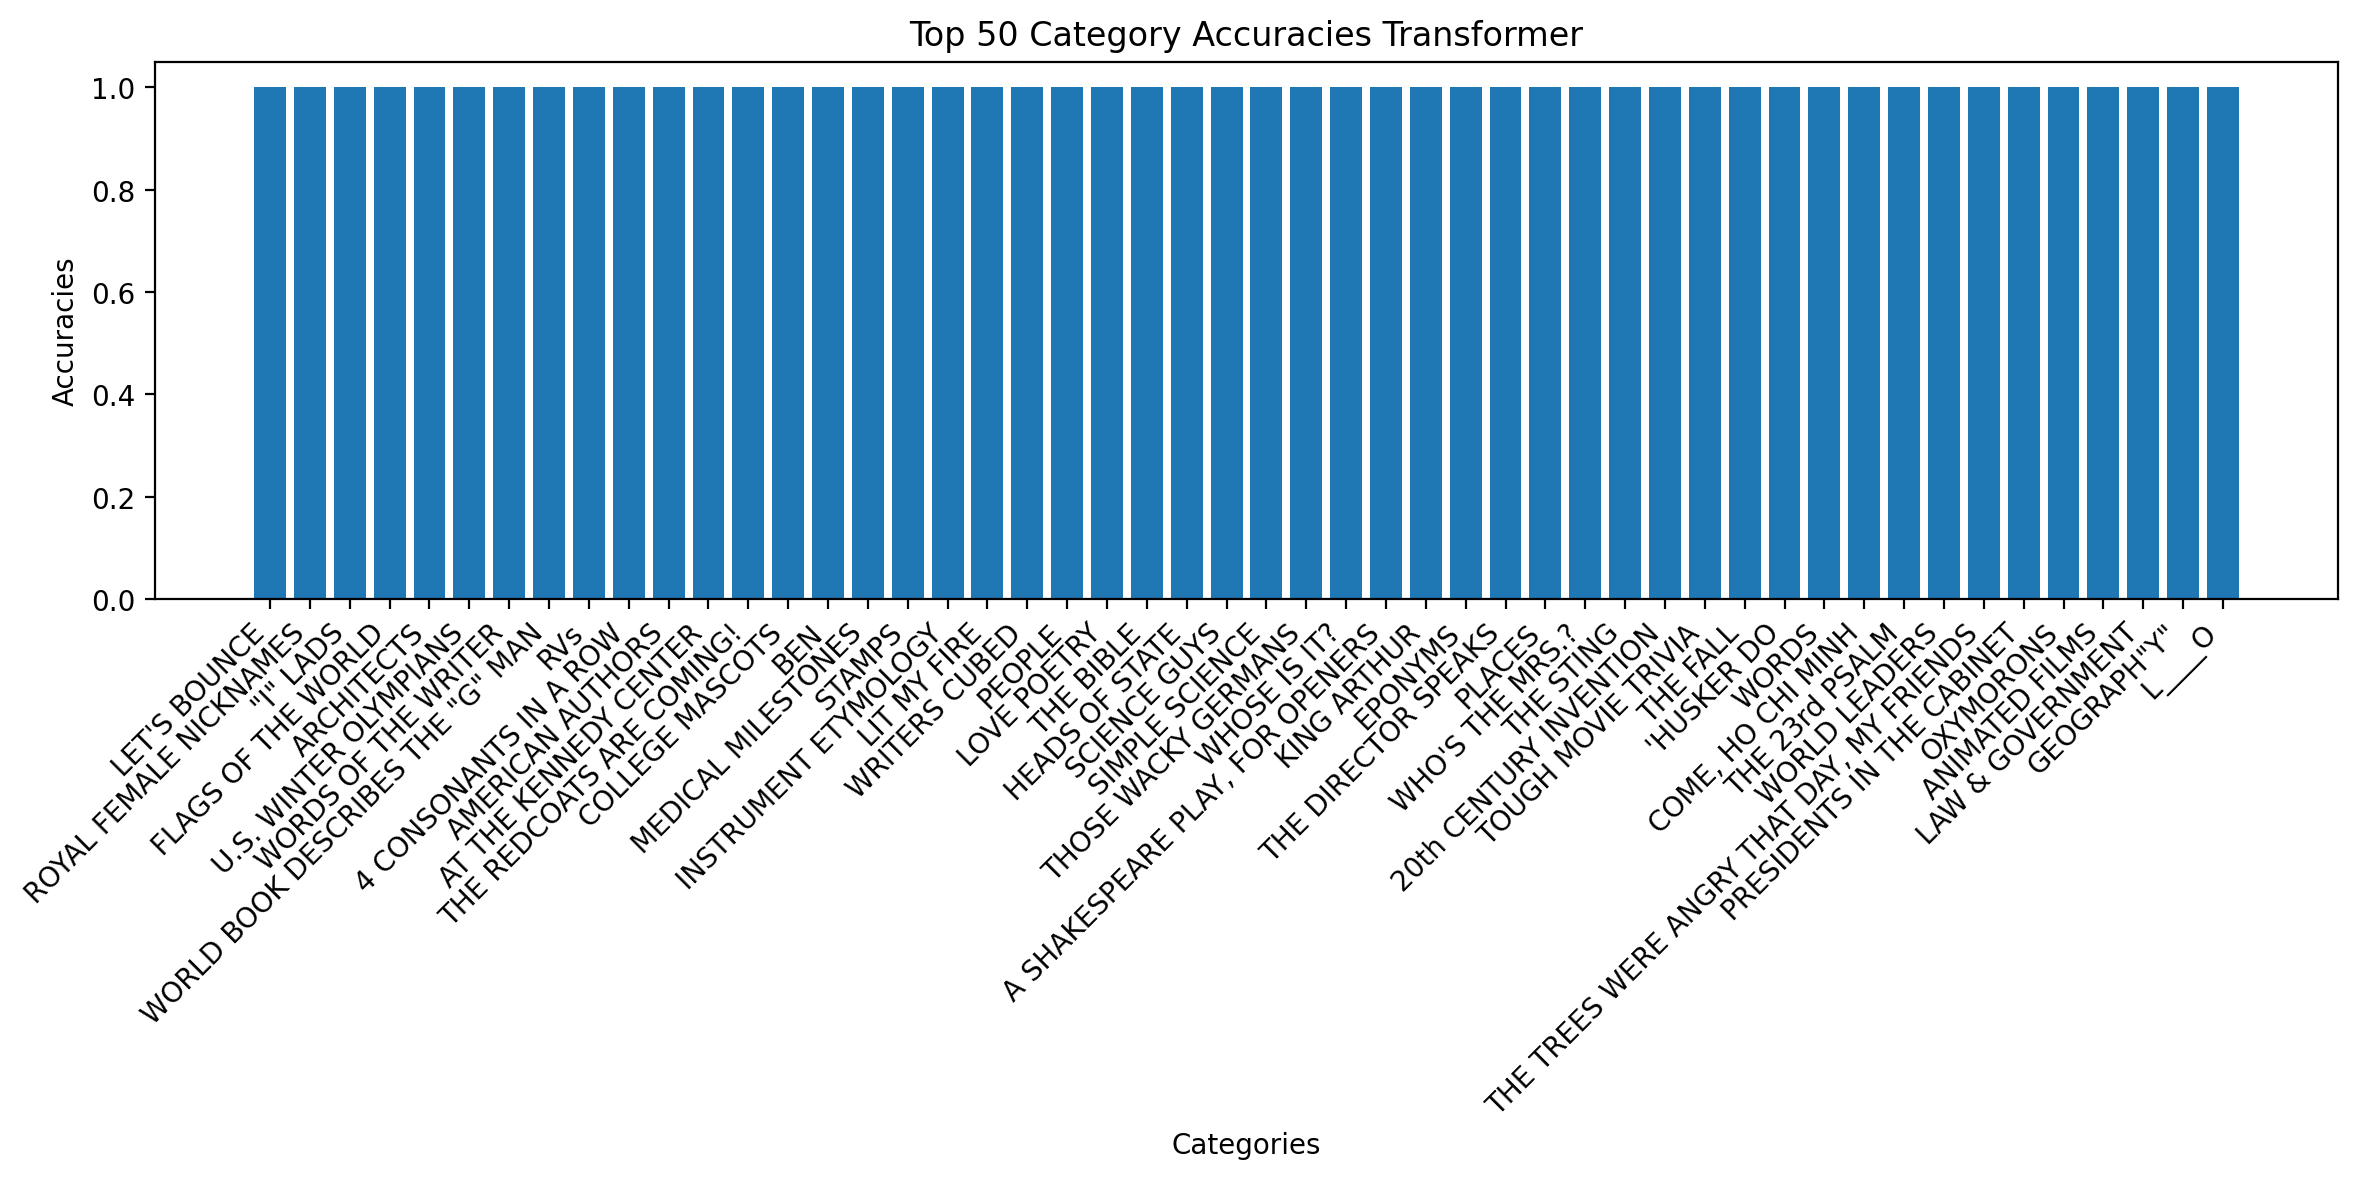

In [17]:
import matplotlib.pyplot as plt

sorted_dict_desc = dict(sorted(category_acc.items(), key=lambda item: item[1], reverse=True))

# Extract top 50 and bottom 50 key-value pairs
top_50 = dict(list(sorted_dict_desc.items())[:50])
bottom_50 = dict(list(sorted_dict_desc.items())[-50:])

# Extract keys and values for plotting
top_keys = list(top_50.keys())
top_values = list(top_50.values())

bottom_keys = list(bottom_50.keys())
bottom_values = list(bottom_50.values())

# Plotting the bar chart for top 50
plt.figure(figsize=(12, 6))
plt.bar(top_keys, top_values)
plt.xlabel('Categories')
plt.ylabel('Accuracies')
plt.title('Top 50 Category Accuracies Transformer')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()